# Clasificación de Deportes en Vídeos con CNN + LSTM

## Introducción

Este notebook aborda el desafío de la **clasificación de acciones en vídeos**, una tarea fundamental en el campo de la visión por computador con aplicaciones que van desde la vigilancia inteligente hasta la interacción humano-robot y el análisis deportivo. Específicamente, nos centraremos en **clasificar vídeos cortos en una de 5 categorías deportivas distintas**.

### Dataset

Utilizaremos el dataset **UCF50**, una colección estándar para la investigación en reconocimiento de acciones proporcionada por la University of Central Florida (UCF). Aunque el dataset completo contiene 50 categorías, para este trabajo **seleccionaremos un subconjunto de 5 deportes**, lo que nos permitirá enfocar nuestros esfuerzos en el desarrollo y la comprensión del modelo.

### Aproximación Técnica: CNN + LSTM

La naturaleza de los vídeos, que combinan información espacial (lo que hay en cada imagen) y temporal (cómo cambia la escena a lo largo del tiempo), sugiere el uso de arquitecturas de Deep Learning híbridas. La metodología propuesta aquí es una combinación de:

1.  **Convolutional Neural Networks (CNNs):** Se emplearán para analizar el contenido espacial de los fotogramas individuales de cada vídeo. Aprovecharemos el **Transfer Learning**, utilizando una CNN pre-entrenada en grandes datasets de imágenes (como ImageNet) para extraer características visuales relevantes de cada frame.
2.  **Long Short-Term Memory (LSTM):** Una vez extraídas las características de varios frames a lo largo del vídeo, utilizaremos una red LSTM (un tipo de Red Neuronal Recurrente - RNN) para modelar las dependencias temporales entre estos frames. La LSTM aprenderá a reconocer los patrones secuenciales característicos de cada deporte.

### Objetivos del Trabajo

Los pasos clave a seguir en este notebook incluyen:

*   Cargar y preparar los datos de las 5 clases de deportes seleccionadas del UCF50.
*   Implementar una función para **muestrear (samplear) frames** de los vídeos.
*   Construir y entrenar el modelo **CNN + LSTM**.
*   Desarrollar una **función de inferencia** que tome la ruta de un vídeo como entrada y devuelva la predicción del deporte.
*   Evaluar el rendimiento del modelo utilizando **métricas de clasificación** estándar y realizar un **test adicional con vídeos externos** (por ejemplo, descargados de YouTube).

## Carga del DataSet, análisis y Preparación

In [1]:
# --- Imports Fundamentales ---
import os
import numpy as np
import cv2 # OpenCV para procesamiento de vídeo/imagen
import matplotlib.pyplot as plt

# --- TensorFlow / Keras ---
import tensorflow as tf
from tensorflow.keras.layers import (Input, TimeDistributed, LSTM, Dense,
                                     Dropout, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence # Para el generador de datos
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# --- Scikit-learn ---
from sklearn.model_selection import train_test_split

In [ ]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [3]:
dataset_path = './UCF50' 

all_items_in_path = os.listdir(dataset_path)
available_sports = sorted([item for item in all_items_in_path if os.path.isdir(os.path.join(dataset_path, item))])

print(f"Deportes disponibles encontrados en '{dataset_path}': ({len(available_sports)} en total)")
for i, sport_name in enumerate(available_sports):
    print(f"  {i+1}. {sport_name}")

# Elijo: Basketball, BenchPress, HighJump, PushUps, PullUps 

Deportes disponibles encontrados en './UCF50': (50 en total)
  1. BaseballPitch
  2. Basketball
  3. BenchPress
  4. Biking
  5. Billiards
  6. BreastStroke
  7. CleanAndJerk
  8. Diving
  9. Drumming
  10. Fencing
  11. GolfSwing
  12. HighJump
  13. HorseRace
  14. HorseRiding
  15. HulaHoop
  16. JavelinThrow
  17. JugglingBalls
  18. JumpRope
  19. JumpingJack
  20. Kayaking
  21. Lunges
  22. MilitaryParade
  23. Mixing
  24. Nunchucks
  25. PizzaTossing
  26. PlayingGuitar
  27. PlayingPiano
  28. PlayingTabla
  29. PlayingViolin
  30. PoleVault
  31. PommelHorse
  32. PullUps
  33. Punch
  34. PushUps
  35. RockClimbingIndoor
  36. RopeClimbing
  37. Rowing
  38. SalsaSpin
  39. SkateBoarding
  40. Skiing
  41. Skijet
  42. SoccerJuggling
  43. Swing
  44. TaiChi
  45. TennisSwing
  46. ThrowDiscus
  47. TrampolineJumping
  48. VolleyballSpiking
  49. WalkingWithDog
  50. YoYo


In [4]:
# --- Configuración ---
dataset_path = './UCF50'
chosen_sports = ['Basketball', 'BenchPress', 'HighJump', 'PushUps', 'PullUps']

# --- Recopilar Rutas y Etiquetas ---
video_files = []
labels = []

# Crear un mapeo de nombre de deporte a etiqueta numérica
label_map = {sport_name: i for i, sport_name in enumerate(chosen_sports)}
print(f"Mapeo de clases: {label_map}")

for i, sport in enumerate(chosen_sports):
    sport_path = os.path.join(dataset_path, sport)
    # Listar todos los archivos en la carpeta del deporte
    for video_name in os.listdir(sport_path):
        # Asegurarse de que es un archivo (y no una subcarpeta, si la hubiera)
        video_path = os.path.join(sport_path, video_name)
        if os.path.isfile(video_path):
            video_files.append(video_path)
            labels.append(i) # Usamos el índice 'i' como etiqueta numérica

print(f"\nSe encontraron {len(video_files)} vídeos para las {len(chosen_sports)} clases seleccionadas.")
# Opcional: Mostrar algunos ejemplos
# print("Primeras 5 rutas de vídeo:", video_files[:5])
# print("Sus correspondientes etiquetas:", labels[:5])

# Convertir a arrays de NumPy para posible uso futuro (ej. split train/test)
video_files = np.array(video_files)
labels = np.array(labels)

Mapeo de clases: {'Basketball': 0, 'BenchPress': 1, 'HighJump': 2, 'PushUps': 3, 'PullUps': 4}

Se encontraron 646 vídeos para las 5 clases seleccionadas.


In [5]:
video_files, labels

(array(['./UCF50/Basketball/v_Basketball_g06_c03.avi',
        './UCF50/Basketball/v_Basketball_g16_c03.avi',
        './UCF50/Basketball/v_Basketball_g20_c01.avi',
        './UCF50/Basketball/v_Basketball_g21_c04.avi',
        './UCF50/Basketball/v_Basketball_g21_c05.avi',
        './UCF50/Basketball/v_Basketball_g16_c02.avi',
        './UCF50/Basketball/v_Basketball_g06_c02.avi',
        './UCF50/Basketball/v_Basketball_g20_c02.avi',
        './UCF50/Basketball/v_Basketball_g21_c06.avi',
        './UCF50/Basketball/v_Basketball_g17_c04.avi',
        './UCF50/Basketball/v_Basketball_g07_c04.avi',
        './UCF50/Basketball/v_Basketball_g20_c03.avi',
        './UCF50/Basketball/v_Basketball_g06_c01.avi',
        './UCF50/Basketball/v_Basketball_g16_c01.avi',
        './UCF50/Basketball/v_Basketball_g20_c07.avi',
        './UCF50/Basketball/v_Basketball_g16_c05.avi',
        './UCF50/Basketball/v_Basketball_g21_c02.avi',
        './UCF50/Basketball/v_Basketball_g17_c01.avi',
        '.

In [6]:
# Número de frames a extraer de cada vídeo
NUM_FRAMES = 20 

# Dimensiones a las que se redimensionará cada frame
IMG_HEIGHT = 128 
IMG_WIDTH = 128 

print(f"\nConfiguración de preprocesamiento:")
print(f"- Frames a extraer por vídeo: {NUM_FRAMES}")
print(f"- Tamaño de cada frame: {IMG_HEIGHT}x{IMG_WIDTH}")


Configuración de preprocesamiento:
- Frames a extraer por vídeo: 20
- Tamaño de cada frame: 128x128


In [7]:
def sample_frames(video_path, num_frames):
    """
    Extrae 'num_frames' frames uniformemente espaciados de un vídeo.

    Args:
        video_path (str): Ruta al archivo de vídeo.
        num_frames (int): Número de frames a extraer.

    Returns:
        list: Una lista de frames (arrays NumPy BGR). Devuelve lista vacía si hay error.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error al abrir el vídeo: {video_path}")
        return frames # Devuelve lista vacía si no se puede abrir

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print(f"Vídeo sin frames o con error: {video_path}")
        cap.release()
        return frames

    # Calcula los índices de los frames a extraer
    # Usamos linspace para obtener índices distribuidos uniformemente
    # Aseguramos que los índices sean enteros
    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    for i in indices:
        # Establece la posición del frame a leer
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()

    # Verificación final (opcional, útil para debug)
    # if len(frames) != num_frames:
    #    print(f"Advertencia: Se esperaban {num_frames} frames pero se obtuvieron {len(frames)} de {video_path}")
    #    # Podríamos decidir rellenar, truncar o descartar aquí si fuera necesario

    return frames

In [8]:
def preprocess_frame(frame, height, width):
    """
    Preprocesa un único frame: redimensiona y normaliza.

    Args:
        frame (np.array): El frame de vídeo (BGR).
        height (int): Altura deseada.
        width (int): Ancho deseado.

    Returns:
        np.array: El frame preprocesado (RGB, normalizado a [0, 1]).
    """
    # Redimensionar
    resized_frame = cv2.resize(frame, (width, height))
    # Convertir de BGR (OpenCV default) a RGB (común en deep learning)
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    # Normalizar los valores de píxeles al rango [0, 1]
    normalized_frame = rgb_frame / 255.0
    return normalized_frame

In [9]:
# --- Ejemplo de uso con el primer vídeo ---
print("\n--- Probando las funciones con el primer vídeo ---")
example_video_path = video_files[0]
print(f"Vídeo de ejemplo: {example_video_path}")
print(f"Etiqueta: {labels[0]} ({chosen_sports[labels[0]]})")

# 1. Samplear frames
sampled_frames = sample_frames(example_video_path, NUM_FRAMES)
print(f"Se samplearon {len(sampled_frames)} frames.")

# 2. Preprocesar cada frame sampleado
processed_sequence = []
if sampled_frames: # Solo si se samplearon frames
    for frame in sampled_frames:
        processed_frame = preprocess_frame(frame, IMG_HEIGHT, IMG_WIDTH)
        processed_sequence.append(processed_frame)

    # Convertir la lista de frames procesados en un array NumPy
    processed_sequence = np.array(processed_sequence)
    print(f"Secuencia procesada lista para el modelo. Forma: {processed_sequence.shape}")
    # La forma debería ser (NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)


--- Probando las funciones con el primer vídeo ---
Vídeo de ejemplo: ./UCF50/Basketball/v_Basketball_g06_c03.avi
Etiqueta: 0 (Basketball)
Se samplearon 20 frames.
Secuencia procesada lista para el modelo. Forma: (20, 128, 128, 3)



Mostrando los 20 frames preprocesados del vídeo de ejemplo:


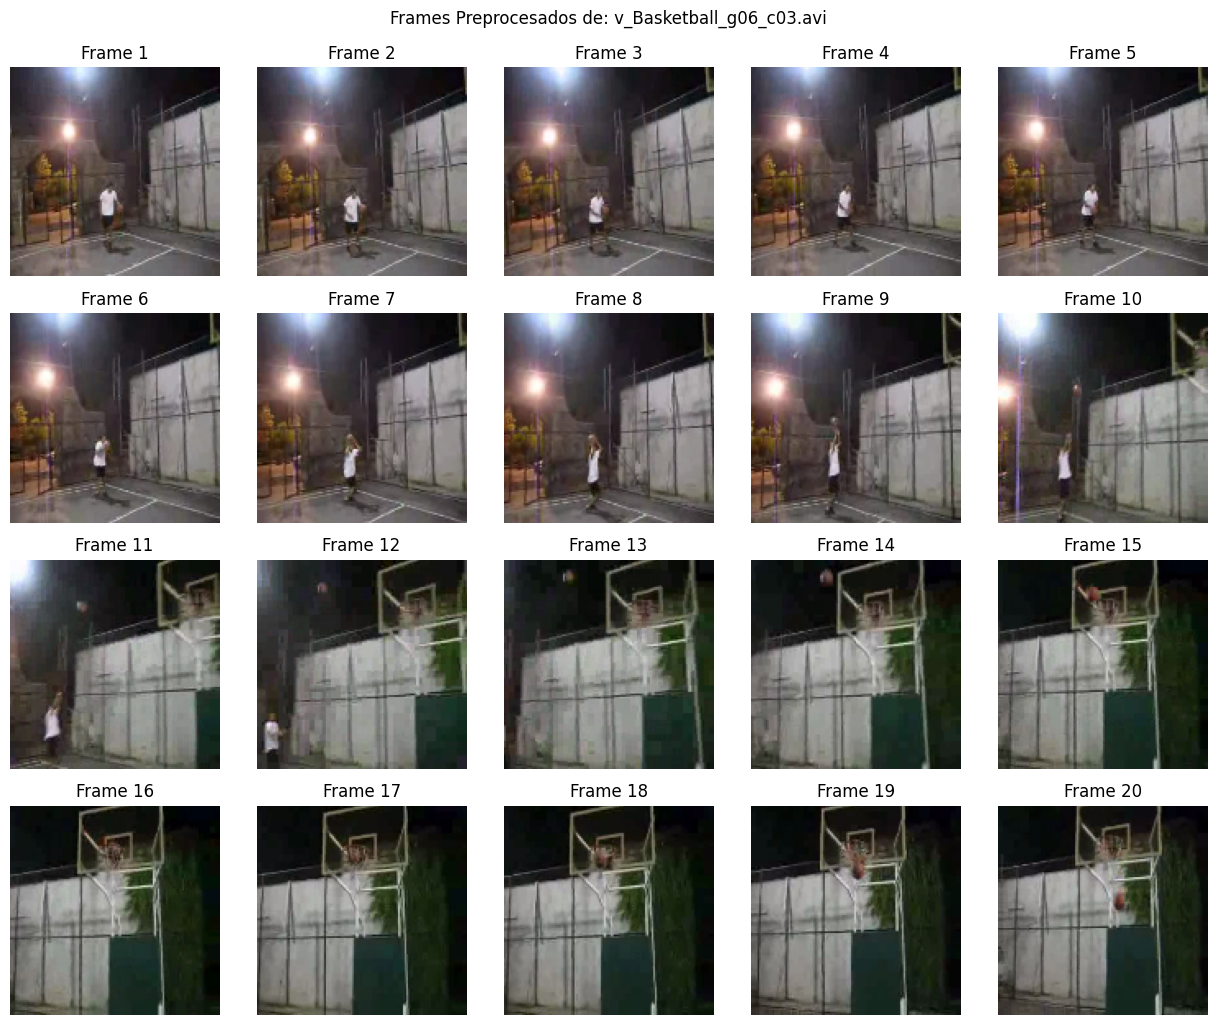

In [10]:
# --- Visualizar los Frames Preprocesados ---

print(f"\nMostrando los {processed_sequence.shape[0]} frames preprocesados del vídeo de ejemplo:")

# Determina el layout de la cuadrícula
num_frames_to_show = processed_sequence.shape[0]
cols = 5  # Número de columnas para mostrar
rows = (num_frames_to_show + cols - 1) // cols # Calcula filas necesarias

# Crea la figura y los ejes
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
axes = axes.flatten() # Simplifica el acceso a los ejes

# Muestra cada frame
for i in range(num_frames_to_show):
    axes[i].imshow(processed_sequence[i]) # Muestra el frame (RGB, [0,1])
    axes[i].set_title(f"Frame {i+1}")
    axes[i].axis('off') # Oculta ejes

# Oculta ejes sobrantes
for j in range(num_frames_to_show, len(axes)):
    axes[j].axis('off')

# Ajusta y muestra el plot
plt.tight_layout()
plt.suptitle(f"Frames Preprocesados de: {os.path.basename(example_video_path)}", y=1.02)
plt.show()

## Arquitectura Red

In [11]:
# --- Constantes del Modelo ---
NUM_CLASSES = 5 
INPUT_SHAPE = (NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3) # Usando las constantes definidas antes

print("--- Configuración de la Arquitectura ---")
print(f"Número de clases: {NUM_CLASSES}")
print(f"Forma de entrada esperada: {INPUT_SHAPE}")

--- Configuración de la Arquitectura ---
Número de clases: 5
Forma de entrada esperada: (20, 128, 128, 3)


In [12]:
print("--- Definiendo la Arquitectura CNN+LSTM ---")
print(f"Número de clases: {NUM_CLASSES}")
print(f"Forma de entrada esperada: {INPUT_SHAPE}")

# --- Capa de Entrada ---
video_input = Input(shape=INPUT_SHAPE, name='video_input')

# --- Base CNN (Extractor de Características) ---
# Carga MobileNetV2 pre-entrenada sin la última capa, con pesos ImageNet
# La forma de entrada es para un solo frame (height, width, channels)
cnn_base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(INPUT_SHAPE[1], INPUT_SHAPE[2], INPUT_SHAPE[3]) # (IMG_HEIGHT, IMG_WIDTH, 3)
)
# Congela los pesos de la CNN base
cnn_base.trainable = False

# --- Combinar CNN Base con Pooling Global ---
# Crea un modelo intermedio que añade GlobalAveragePooling2D a la salida de cnn_base
# Esto produce un vector de características por frame
cnn_extractor = Model(inputs=cnn_base.input,
                      outputs=GlobalAveragePooling2D()(cnn_base.output),
                      name='cnn_feature_extractor')
cnn_extractor.trainable = False # Asegura que todo el extractor esté congelado

# --- Aplicar CNN a cada Frame ---
# TimeDistributed aplica 'cnn_extractor' a cada paso temporal (frame) de la entrada
features_sequence = TimeDistributed(cnn_extractor, name='time_distributed_cnn')(video_input)
# Salida -> (batch_size, NUM_FRAMES, cnn_features)

# --- Capa LSTM ---
# Procesa la secuencia de características. return_sequences=False (solo salida final)
lstm_out = LSTM(64, return_sequences=False, name='lstm_layer')(features_sequence)
# Salida -> (batch_size, lstm_units)

# --- Capas de Clasificación ---
# Dropout para regularización
x = Dropout(0.5, name='dropout_layer')(lstm_out)
# Capa Dense final con activación softmax
output = Dense(NUM_CLASSES, activation='softmax', name='output_layer')(x)
# Salida -> (batch_size, NUM_CLASSES)

# --- Crear el Modelo Final ---
model = Model(inputs=video_input, outputs=output, name='cnn_lstm_classifier')

# --- Mostrar Resumen del Modelo ---
print("\n--- Resumen del Modelo Creado ---")
model.summary()


--- Definiendo la Arquitectura CNN+LSTM ---
Número de clases: 5
Forma de entrada esperada: (20, 128, 128, 3)


2025-04-22 20:33:51.437945: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-22 20:33:51.437972: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-22 20:33:51.437976: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-22 20:33:51.437990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 20:33:51.437999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



--- Resumen del Modelo Creado ---


Model: "cnn_lstm_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)        │ (None, 20, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_cnn            │ (None, 20, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │       344,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,629 (9.93 MB)

 Trainable params: 344,645 (1.31 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento del modelo

In [13]:
# Divide los datos (80% entrenamiento, 20% validación)
# stratify=labels asegura que la proporción de clases sea similar en ambos conjuntos
X_train, X_val, y_train, y_val = train_test_split(
    video_files,
    labels,
    test_size=0.20,       # 20% para validación
    random_state=42,      # Para reproducibilidad
    stratify=labels       # Importante para mantener proporción de clases
)

print("--- División de Datos ---")
print(f"Total vídeos: {len(video_files)}")
print(f"Vídeos de entrenamiento: {len(X_train)}")
print(f"Vídeos de validación: {len(X_val)}")

--- División de Datos ---
Total vídeos: 646
Vídeos de entrenamiento: 516
Vídeos de validación: 130


In [14]:
class VideoDataGenerator(tf.keras.utils.Sequence):
    """
    Generador para cargar y preprocesar lotes de secuencias de vídeo.
    """
    def __init__(self, video_paths, labels, batch_size, num_frames,
                 height, width, num_classes, shuffle=True):
        self.video_paths = video_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.height = height
        self.width = width
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.video_paths))
        self.on_epoch_end() # Llama a shuffle al inicio si está habilitado

    def __len__(self):
        # Número de lotes por época
        return int(np.ceil(len(self.video_paths) / self.batch_size))

    def __getitem__(self, index):
        # Genera un lote de datos
        # Obtiene los índices del lote actual
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Obtiene las rutas y etiquetas para esos índices
        batch_video_paths = [self.video_paths[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]

        # Inicializa los arrays del lote
        # X será el batch de secuencias de frames: (batch_size, num_frames, H, W, C)
        # y será el batch de etiquetas: (batch_size,) [si usamos SparseCategoricalCrossentropy]
        X = np.empty((len(batch_indexes), self.num_frames, self.height, self.width, 3), dtype=np.float32)
        y = np.empty((len(batch_indexes)), dtype=int)

        # Genera datos para cada vídeo en el lote
        for i, video_path in enumerate(batch_video_paths):
            # 1. Samplear frames del vídeo
            frames = sample_frames(video_path, self.num_frames) # Usa la función definida antes

            # 2. Preprocesar cada frame
            processed_frames = []
            for frame in frames:
                processed = preprocess_frame(frame, self.height, self.width) # Usa la función definida antes
                processed_frames.append(processed)

            # 3. Si se obtuvieron menos frames de los esperados (vídeo corto/error),
            #    una estrategia simple es duplicar el último frame hasta completar
            if len(processed_frames) < self.num_frames:
                # Crea frames de relleno duplicando el último frame válido
                last_frame = processed_frames[-1] if processed_frames else np.zeros((self.height, self.width, 3))
                padding = [last_frame] * (self.num_frames - len(processed_frames))
                processed_frames.extend(padding)
            # Asegúrate de que la secuencia tenga exactamente num_frames
            processed_sequence = np.array(processed_frames[:self.num_frames])

            # Asigna la secuencia procesada y la etiqueta al lote
            X[i,] = processed_sequence
            y[i] = batch_labels[i]

        return X, y

    def on_epoch_end(self):
        # Reordena los índices al final de cada época si shuffle=True
        if self.shuffle:
            np.random.shuffle(self.indexes)


# --- Instanciar los Generadores ---
BATCH_SIZE = 8 

train_generator = VideoDataGenerator(
    video_paths=X_train,
    labels=y_train,
    batch_size=BATCH_SIZE,
    num_frames=NUM_FRAMES,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    num_classes=NUM_CLASSES,
    shuffle=True
)

val_generator = VideoDataGenerator(
    video_paths=X_val,
    labels=y_val,
    batch_size=BATCH_SIZE,
    num_frames=NUM_FRAMES,
    height=IMG_HEIGHT,
    width=IMG_WIDTH,
    num_classes=NUM_CLASSES,
    shuffle=False # No es necesario barajar la validación
)

print("\n--- Generadores de Datos Listos ---")
print(f"Tamaño del lote (Batch Size): {BATCH_SIZE}")
print(f"Pasos por época (entrenamiento): {len(train_generator)}")
print(f"Pasos por época (validación): {len(val_generator)}")


--- Generadores de Datos Listos ---
Tamaño del lote (Batch Size): 8
Pasos por época (entrenamiento): 65
Pasos por época (validación): 17


In [15]:
# --- Compilar el Modelo ---

initial_learning_rate = 0.0001 # 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Como nuestras etiquetas 'y' son enteros (0, 1, 2, 3, 4), usamos
# SparseCategoricalCrossentropy. Si fueran one-hot, usaríamos CategoricalCrossentropy.
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Compilamos el modelo
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy'] 
)

print("\n--- Modelo Compilado ---")
print(f"Optimizador: Adam (lr={initial_learning_rate})")
print(f"Función de Pérdida: SparseCategoricalCrossentropy")
print(f"Métricas: ['accuracy']")


--- Modelo Compilado ---
Optimizador: Adam (lr=0.0001)
Función de Pérdida: SparseCategoricalCrossentropy
Métricas: ['accuracy']


In [16]:
# --- Callbacks ---

# 1. ModelCheckpoint: Guarda el modelo automáticamente
#    filepath: dónde guardar. Puede incluir placeholders como {epoch} o {val_accuracy}
#    save_best_only=True: Solo guarda si la métrica monitorizada ('val_accuracy') mejora.
#    monitor='val_accuracy': La métrica a observar.
#    mode='max': Queremos maximizar la precisión.
checkpoint_filepath = 'best_cnn_lstm_model.keras' # Keras recomienda la extensión .keras
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # Guarda el modelo completo (arquitectura + pesos)
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# 2. EarlyStopping: Detiene el entrenamiento si no hay mejora
#    monitor='val_accuracy': Métrica a observar.
#    patience=5: Número de épocas a esperar sin mejora antes de detener.
#    mode='max': Buscamos maximizar la métrica.
#    restore_best_weights=True: Al detenerse, carga los pesos de la mejor época encontrada.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5, 
    mode='max',
    restore_best_weights=True # Vuelve a los mejores pesos al final
)

# Lista de callbacks a usar
callbacks_list = [model_checkpoint_callback, early_stopping_callback]

print("\n--- Callbacks Definidos ---")
print(f"ModelCheckpoint: Guardará el mejor modelo en '{checkpoint_filepath}' basado en val_accuracy.")
print(f"EarlyStopping: Se detendrá si val_accuracy no mejora en 5 épocas (restaurando mejores pesos).")


--- Callbacks Definidos ---
ModelCheckpoint: Guardará el mejor modelo en 'best_cnn_lstm_model.keras' basado en val_accuracy.
EarlyStopping: Se detendrá si val_accuracy no mejora en 5 épocas (restaurando mejores pesos).


In [17]:
# --- Entrenamiento ---

EPOCHS = 20 

print(f"\n--- Iniciando Entrenamiento (máximo {EPOCHS} épocas) ---")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks_list, # Pasa la lista de callbacks
)

print("\n--- Entrenamiento Finalizado ---")


--- Iniciando Entrenamiento (máximo 20 épocas) ---
Epoch 1/20


2025-04-22 20:34:00.146623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


65/65 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.2801 - loss: 1.6603 - val_accuracy: 0.7462 - val_loss: 1.0742
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 630ms/step - accuracy: 0.6834 - loss: 1.0139 - val_accuracy: 0.9385 - val_loss: 0.6605
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 644ms/step - accuracy: 0.8338 - loss: 0.6686 - val_accuracy: 0.9692 - val_loss: 0.4057
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.9081 - loss: 0.4450 - val_accuracy: 0.9846 - val_loss: 0.2853
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.9568 - loss: 0.3244 - val_accuracy: 0.9769 - val_loss: 0.2120
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.9432 - loss: 0.2255 - val_accuracy: 0.9923 - val_loss: 0.1501
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.9770 - loss: 0.1812 - val_accuracy: 1.0000 - val_loss: 0.1126
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.9942 - loss: 0.1203 - val_accuracy: 0.9923 

## TEST Vídeos externos

In [18]:
def predict_single_video(video_path, loaded_model, num_frames, height, width, class_names):
    """
    Realiza una predicción para un único archivo de vídeo.

    Args:
        video_path (str): Ruta al archivo de vídeo.
        loaded_model (tf.keras.Model): El modelo Keras entrenado y cargado.
        num_frames (int): Número de frames a samplear (igual que en entrenamiento).
        height (int): Altura del frame (igual que en entrenamiento).
        width (int): Ancho del frame (igual que en entrenamiento).
        class_names (list): Lista con los nombres de las clases en el orden correcto.

    Returns:
        str: Nombre de la clase predicha, o None si ocurre un error.
    """
    # 1. Samplear frames
    frames = sample_frames(video_path, num_frames)

    if not frames:
        print(f"Error: No se pudieron samplear frames de {video_path}")
        return None

    # 2. Preprocesar frames
    processed_frames = []
    for frame in frames:
        processed = preprocess_frame(frame, height, width)
        processed_frames.append(processed)

    # 3. Gestionar si se obtuvieron menos frames (padding)
    if len(processed_frames) < num_frames:
        last_frame = processed_frames[-1] if processed_frames else np.zeros((height, width, 3))
        padding = [last_frame] * (num_frames - len(processed_frames))
        processed_frames.extend(padding)

    processed_sequence = np.array(processed_frames[:num_frames])

    # 4. Añadir dimensión de Batch (el modelo espera un lote, aunque sea de 1)
    # La forma debe ser (1, num_frames, height, width, channels)
    input_data = np.expand_dims(processed_sequence, axis=0)

    # 5. Realizar predicción
    predictions = loaded_model.predict(input_data)
    # 'predictions' es un array de probabilidades, ej. [[0.1, 0.05, 0.8, 0.03, 0.02]]

    # 6. Obtener índice de la clase con mayor probabilidad
    predicted_index = np.argmax(predictions[0]) # Usamos [0] porque solo hay un elemento en el lote

    # 7. Mapear índice a nombre de clase
    predicted_class_name = class_names[predicted_index]

    return predicted_class_name


In [19]:
def predict_sport_from_path(video_path, loaded_model, num_frames, height, width, class_names):
    """
    Predice el deporte de un vídeo local dado su path.

    Args:
        video_path (str): Ruta al archivo de vídeo local.
        loaded_model (tf.keras.Model): El modelo Keras entrenado y cargado.
        num_frames (int): Número de frames a samplear.
        height (int): Altura del frame para preprocesar.
        width (int): Ancho del frame para preprocesar.
        class_names (list): Lista con los nombres de las clases.

    Returns:
        str: El nombre (etiqueta) del deporte predicho.
             Devuelve None si hay un error al procesar el vídeo.
    """
    # Verifica si el archivo existe
    if not os.path.exists(video_path):
        print(f"Error: El archivo no existe en la ruta: {video_path}")
        return None

    # 1. Samplear frames
    frames = sample_frames(video_path, num_frames)
    if not frames:
        print(f"Error al samplear frames de: {video_path}")
        return None

    # 2. Preprocesar frames y manejar padding
    processed_frames = []
    for frame in frames:
        processed = preprocess_frame(frame, height, width)
        processed_frames.append(processed)

    if len(processed_frames) < num_frames:
        last_frame = processed_frames[-1] if processed_frames else np.zeros((height, width, 3))
        padding = [last_frame] * (num_frames - len(processed_frames))
        processed_frames.extend(padding)
    processed_sequence = np.array(processed_frames[:num_frames])

    # 3. Preparar entrada para el modelo (añadir dimensión de lote)
    input_data = np.expand_dims(processed_sequence, axis=0) # Shape: (1, num_frames, H, W, C)

    # 4. Predecir
    predictions = loaded_model.predict(input_data) # Shape: (1, num_classes)

    # 5. Obtener etiqueta predicha
    predicted_index = np.argmax(predictions[0])
    predicted_label = class_names[predicted_index]

    return predicted_label

In [21]:
video_test_paths = ['youtube_test_videos/test_basket.mov',
                     'youtube_test_videos/test_BenchPress.mov',
                     'youtube_test_videos/test_highjump.mov',
                     'youtube_test_videos/test_pulllups.mov',
                     'youtube_test_videos/test_pushups.mov']                     

for video in video_test_paths:
    print(f"\n--- Realizando predicción para: {video} ---")
    # Llama a la función
    predicted_label = predict_sport_from_path(
        video,
        model, # El modelo cargado
        NUM_FRAMES,
        IMG_HEIGHT,
        IMG_WIDTH,
        chosen_sports # La lista de nombres de deportes
    )

    # Muestra el resultado
    if predicted_label:
        print(f"El deporte predicho es: {predicted_label}")
    else:
        print("No se pudo obtener una predicción.")


--- Realizando predicción para: youtube_test_videos/test_basket.mov ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
El deporte predicho es: Basketball

--- Realizando predicción para: youtube_test_videos/test_BenchPress.mov ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
El deporte predicho es: BenchPress

--- Realizando predicción para: youtube_test_videos/test_highjump.mov ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
El deporte predicho es: HighJump

--- Realizando predicción para: youtube_test_videos/test_pulllups.mov ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
El deporte predicho es: PullUps

--- Realizando predicción para: youtube_test_videos/test_pushups.mov ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
El deporte predicho es: PushUps


## Conclusiones del Proyecto

Este proyecto desarrolló con éxito un **clasificador de acciones deportivas (CNN+LSTM)** capaz de distinguir entre 5 clases ('Basketball', 'BenchPress', 'HighJump', 'PushUps', 'PullUps') del dataset UCF50.

**Puntos Clave:**

*   **Arquitectura:** Se utilizó una CNN pre-entrenada (MobileNetV2) para extraer características espaciales y una LSTM para modelar la secuencia temporal, demostrando ser un enfoque efectivo.
*   **Entrenamiento:** El modelo se entrenó eficientemente usando Transfer Learning, un generador de datos personalizado y aceleración por GPU (Apple Silicon M3), convergiendo rápidamente.
*   **Resultados:** Se alcanzó una **precisión del 100%** tanto en el conjunto de **validación** interno (datos de UCF50) como en una **prueba externa** inicial con 5 vídeos específicos (uno por clase).

**Conclusión:**

El modelo aprendió perfectamente a diferenciar las 5 acciones seleccionadas en los datos disponibles. La combinación CNN+LSTM, potenciada por Transfer Learning, es muy adecuada para esta tarea. Si bien los resultados iniciales en el test externo son excelentes, se recomienda una evaluación más extensa con vídeos más diversos para confirmar la robustez de la generalización del modelo.

In [22]:
!pip freeze > requirements.txt